## Try to replicate SMT

In [1]:
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from tools import *


# Check that MPS is available
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("MPS is enabled!")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("cuda is enabled!")



MPS is enabled!
MPS is enabled!


### 1. Generate data from Archimedean spiral

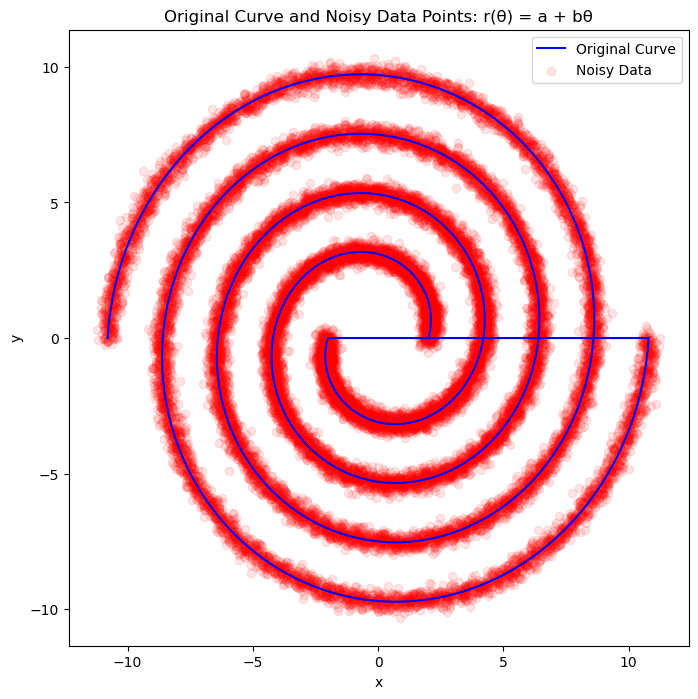

In [2]:
data = GenerateDataset()

## 2. Sparse coding

In [3]:
data_tensor = torch.tensor(data, dtype=torch.float,device = device)

# Create an instance of SparseCoding model
model = SparseCoding(data_size=data_tensor.shape[0], activ_dim=data_tensor.shape[1], basisfunc_num=700, sparsity_level=0)


# Define optimizer for Biasis update
optimizer = optim.Adam([model.Activ, model.Basis], lr=0.01)

# Number of optimization steps
num_epochs = 3000

# Training loop
for epoch in range(num_epochs):

    # Update A
    dist = torch.norm(data_tensor[:, None, :] - model.Basis[None, :, :], p=2, dim=2)
    min_indices = torch.argmin(dist, dim=1)  # Find indices of largest elements in each row
    model.Activ.zero_()
    model.Activ.scatter_(1, min_indices.unsqueeze(1), 1)

    # Update B
    cost = model.loss(data_tensor)
    
    # Zero gradients, perform a backward pass, and update the weights
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()

    # Print progress
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Cost = {cost}')

    if cost <= 1e-2:
        print('training ended!')
        break

# After training, you can use the learned dictionary to encode new data
encoded_data = model.Activ @ model.Basis
print("Encoded data shape:", encoded_data.shape)



Epoch [10/3000], Cost = 0.17636649310588837
Epoch [20/3000], Cost = 0.13459813594818115
Epoch [30/3000], Cost = 0.10595647245645523
Epoch [40/3000], Cost = 0.0860837772488594
Epoch [50/3000], Cost = 0.07274302840232849
Epoch [60/3000], Cost = 0.06390274316072464
Epoch [70/3000], Cost = 0.05773122236132622
Epoch [80/3000], Cost = 0.053182750940322876
Epoch [90/3000], Cost = 0.04985866695642471
Epoch [100/3000], Cost = 0.04774036258459091
Epoch [110/3000], Cost = 0.04642350599169731
Epoch [120/3000], Cost = 0.04553087428212166
Epoch [130/3000], Cost = 0.044962797313928604
Epoch [140/3000], Cost = 0.04456866532564163
Epoch [150/3000], Cost = 0.04426831007003784
Epoch [160/3000], Cost = 0.04403797537088394
Epoch [170/3000], Cost = 0.04383186995983124
Epoch [180/3000], Cost = 0.043638478964567184
Epoch [190/3000], Cost = 0.0434747114777565
Epoch [200/3000], Cost = 0.043304238468408585
Epoch [210/3000], Cost = 0.04313824325799942
Epoch [220/3000], Cost = 0.04295516386628151
Epoch [230/3000],

### Plot learnt dictionary and clustered data points

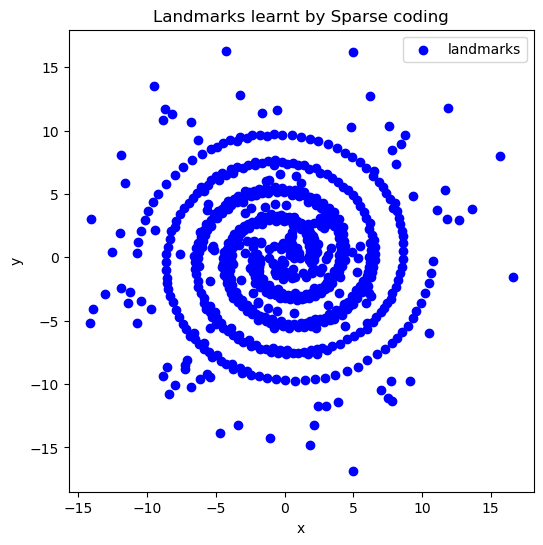

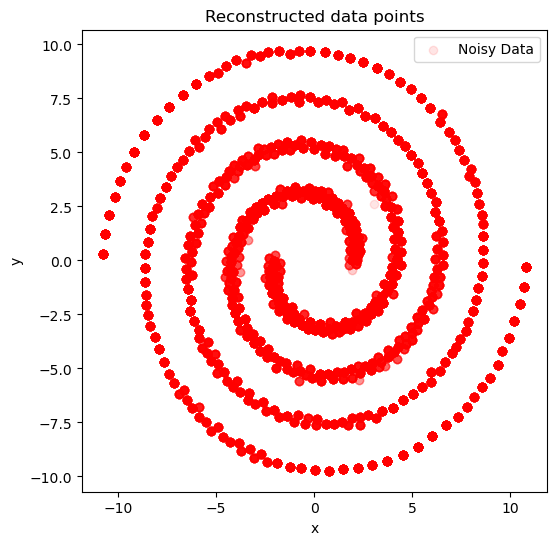

1.0


In [4]:

# return sum_squared_error/num_samples
Bas = model.Basis.detach().cpu()
Act = model.Activ.detach().cpu()

recon = Act @ Bas
# Plotting in polar coordinates

# Original curve label='Original Curve', color='blue')
model.plot_basis()

plt.figure(figsize=[6, 6])

# Noisy data points
ax = plt.subplot(111)
ax.scatter(recon[:, 0], recon[:, 1], label='Noisy Data', color='red', alpha=0.1)

# Setting the title and labels
ax.set_title("Reconstructed data points")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.legend()
plt.show()

# Show the plot

print(np.linalg.norm(Act[0,:]))


## 2. Assign similarity (Define D)

### 2.1 Try apply manifold learning on basis, not full data

In [5]:
print(model.Basis.shape)

torch.Size([700, 2])


In [31]:
## Compute K-nearest neighbors for each element in model.Basis


# Compute K-nearest neighbors
neighbors_indices = model.KNN(5).detach().cpu()
print("K-nearest neighbors indices:")
print(neighbors_indices)



K-nearest neighbors indices: tensor([[692, 446, 268, 527, 300],
        [518, 205, 486, 548, 298],
        [351, 173, 113,   5, 102],
        ...,
        [249, 684, 515,  33,  74],
        [194, 615,  79, 132, 392],
        [570,  87, 364, 200, 352]])
tensor([[692, 446, 268, 527, 300],
        [518, 205, 486, 548, 298],
        [351, 173, 113,   5, 102],
        ...,
        [249, 684, 515,  33,  74],
        [194, 615,  79, 132, 392],
        [570,  87, 364, 200, 352]])


torch.Size([5, 2])
torch.Size([5, 2])


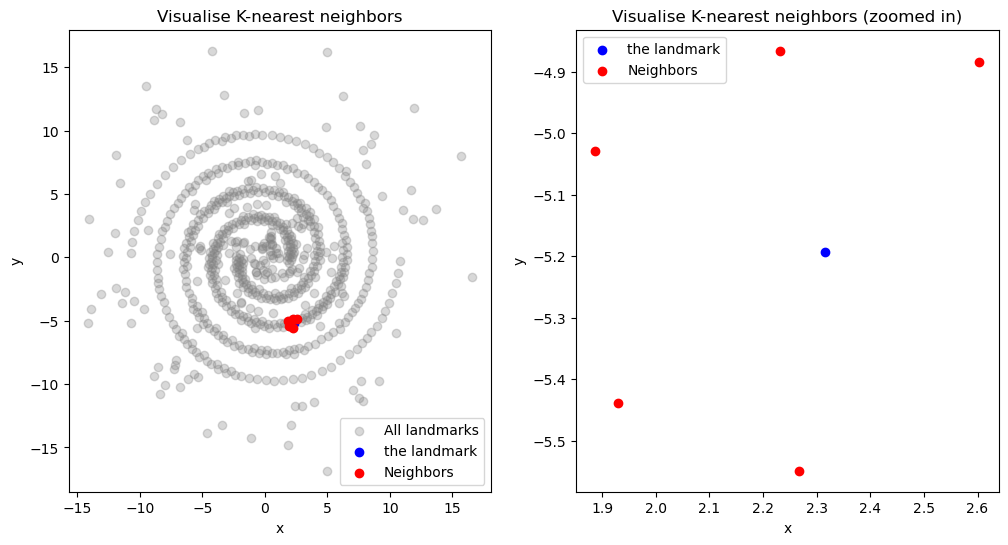

In [29]:

idx = 360

fig, [ax, ax1] = plt.subplots(figsize=[12,6],nrows=1, ncols=2)

# plot dictionary elements
ax.scatter(Bas[:, 0], Bas[:, 1], label='All landmarks', color='gray', alpha=0.3)

ax.scatter(Bas[idx,0], Bas[idx,1], label='the landmark', color='blue', alpha=1)
neighbors = Bas[neighbors_indices[idx],:]
print(neighbors.shape)
ax.scatter(neighbors[:,0], neighbors[:,1], label='Neighbors', color='red', alpha=1)

# Setting the title and labels
ax.set_title("Visualise K-nearest neighbors")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.legend()

ax1.scatter(Bas[idx,0], Bas[idx,1], label='the landmark', color='blue', alpha=1)
neighbors = Bas[neighbors_indices[idx],:]
print(neighbors.shape)
ax1.scatter(neighbors[:,0], neighbors[:,1], label='Neighbors', color='red', alpha=1)

# Setting the title and labels
ax1.set_title("Visualise K-nearest neighbors (zoomed in)")
ax1.set_xlabel("x")
ax1.set_ylabel("y")
ax1.legend()
plt.show()


In [8]:
## (a) Goal: minimising distance between neighbours

model.Basis

tensor([[-4.2115, -0.0872],
        [-6.3097,  1.1524],
        [-1.3633, -5.0448],
        ...,
        [-9.1888,  5.0147],
        [11.8369,  3.0381],
        [ 4.4025, -0.2311]], device='mps:0', requires_grad=True)

In [9]:
## (b) Goal: keep topology by using interpolation (LLE on dictionary elements)